## Introduction

We consider the data freMTPL2freq included in the R package CASdatasets1 for claim amount and exposure modeling. This data comprises a French motor third-party liability (MTPL) insurance portfolio with corresponding claim counts and amounts observed in the period of exposure. The task is to model the expected amount of damage per policyholder and year based on the risk characteristics of the customers. This value is the basis for calculating a fair insurance premium. We briefly describe the dataset. We have 2 datasets. The first dataset contains individual car insurance
policies and for each policy we have 12 variables: 

    -IDpol: ID of the contract
    -ClaimNb: Number of claims in the insurance period
    -Exposure: Length of the insurance period (in years)
    -Area: Area code of the policyholder
    -VehPower: Power of the insured vehicle 
    -VehAge: Age of the insured vehicle  
    -DrivAge: age of the policyholder  
    -BonusMalus: no-claims bonus (French equivalent of no-claims class)  
    -VehBrand: Brand of the insured vehicle  
    -VehGas: power of the insured vehicle  
    -Density: number of inhabitants per km2 in the policyholder's place of residence 
    -Region: region of the policyholder 

The second dataset contains the claim amount for those policyholders who has sumbitted claims: 

    -IDpol: ID of the contract
    -ClaimAmount: Amount of the individual claims expenses (several entries per contract if there were multiple claims in the period)

First we load the necessary packages. Additionally, the data is imported. 

In [146]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy import stats
from sklearn.tree import plot_tree
import pandas as pd
import arff
data_freq = arff.load('D:/DS/Challenges/HUK/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower","VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('D:/DS/Challenges/HUK/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

The data frame "df_freq" contains the features of policyholders plus the amount of exposure. The data frame "df_sev" contains the "ClaimAmount" for some of these policyholders. The tables can be merged using "IDpol" column. This results in a new data frame containing all the policyholders who received an amount upon making claims. Note that, we only consider entries for which the ClaimAmount exists. The entries that do not have a corresponding ClaimAmount are considered unsettled claims. Additionally, entries for which an amount is claimed but the features do not exist are considered as missing. These entries are omitted. 

We notice that there are policyholders with more than one claim. For these policyholders, we will sum up their claim amounts. In this way, multiple entries corresponding to these policyholders will be replaced with one entry. 

In [147]:
# Merging 2 datasets
df = pd.merge(df_freq, df_sev, how = 'inner', on = 'IDpol')
# Grouping by claim numbers and summing up the amount of claims per policyholder
df = df.groupby(by = list(df.columns[0:-1]), as_index = False).sum()
# moving the Exposure column to the end of dataframe
ex = df.pop('Exposure')
df.insert(11, ex.name, ex)

df

,IDpol,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimAmount
0,139.0,1.0,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',0.75,303.00
1,190.0,1.0,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',0.14,1981.84
2,414.0,1.0,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',0.14,1456.55
3,424.0,2.0,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',0.62,10834.00
4,463.0,1.0,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',0.31,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24939,6113521.0,1.0,'C',4.0,1.0,26.0,60.0,'B12',Diesel,311.0,'R82',0.18,1324.40
24940,6113793.0,1.0,'C',7.0,2.0,51.0,50.0,'B12',Diesel,178.0,'R72',0.14,1769.88
24941,6113817.0,1.0,'D',4.0,0.0,35.0,51.0,'B12',Regular,1719.0,'R82',0.17,1288.28
24942,6113834.0,2.0,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',0.17,12230.40


We drop the IDpol column as it is not needed anymore. Additionally, the claim number is determined only after making claims and cannot be considered a predictive feature. Hence we drop it! Of note, the aggregated data contains no missing values.

In [148]:
# Drop IDpol: The IDpol is not needed anymore
df = df.drop(columns = ['IDpol', 'ClaimNb'])
df.isna().sum()

Area           0
VehPower       0
VehAge         0
DrivAge        0
BonusMalus     0
VehBrand       0
VehGas         0
Density        0
Region         0
Exposure       0
ClaimAmount    0
dtype: int64

## Exploratory Data Analysis

We start by producing the fundamental descriptive statistcs of the data.

In [149]:
df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimAmount
count,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,2.494400e+04
mean,6.468970,7.386225,45.139793,64.930164,1984.306166,0.692669,2.401749e+03
std,2.012848,5.173621,14.658487,19.864719,4119.719566,0.313969,3.026475e+04
min,4.000000,0.000000,18.000000,50.000000,2.000000,0.002740,1.000000e+00
25%,5.000000,3.000000,34.000000,50.000000,111.000000,0.450000,7.497875e+02
50%,6.000000,7.000000,45.000000,55.000000,495.000000,0.760000,1.172000e+03
75%,7.000000,11.000000,54.000000,76.000000,2120.000000,1.000000,1.346400e+03
max,15.000000,99.000000,99.000000,228.000000,27000.000000,2.000000,4.075401e+06


The claim amount variable has a price unit and it is disproportionally (75% of data points are less than 2000 and max value is in millions). In order to be able to explore the data properly, the log transform of this variable will be considered. In this way, not only the variable is scaled closer to the other continuous variables, but also the normality of the variable can be checked. 

In [150]:
df_explore = df.copy(deep = True)
df_explore['ClaimAmount'] = np.log10(df_explore['ClaimAmount'])

Next we plot the histogram of ClaimAmount. To check the normality further, we also produce the Q-Q plots against the standard normal distribution. Furthermore, the Pearson (linear) correlation between continuous variabes are derived. 

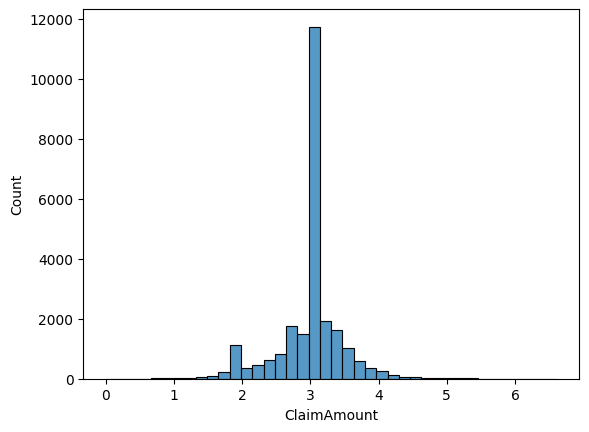

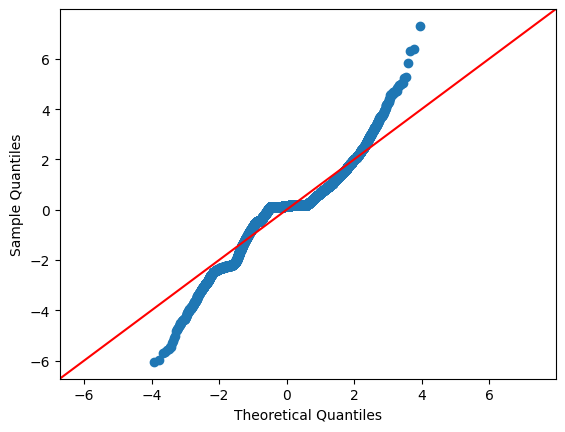

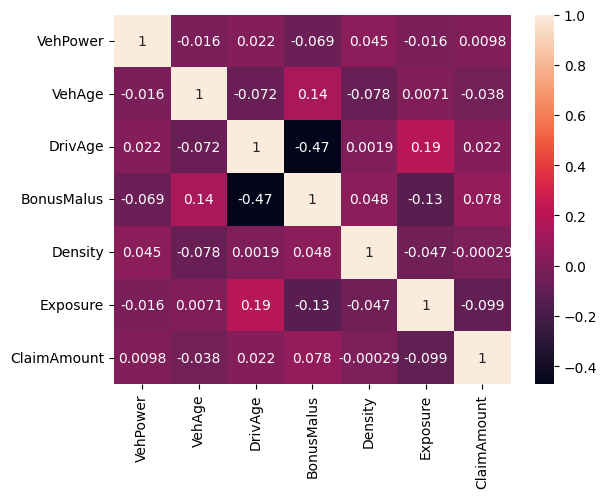

In [151]:
# Correlation between variables
sns.histplot(x = 'ClaimAmount', data = df_explore, bins = 40)
ca = df_explore['ClaimAmount']
ca = (ca - ca.mean())/(ca.std())
sm.qqplot(data = ca, line = '45')
plt.subplots()
sns.heatmap(df_explore.select_dtypes(include = 'float').corr(), annot = True)
plt.show()

The ClaimAmount looks non-normal. The distribution is not completely symmetric Around 50% of values are also concentrated in a small range (i.e., extreme kurtosis). The Q-Q plots actually show the discrepancy to the standard normal distribution much better. The tails of the ClaimAmount distribution depart from those of the normal distribution.  

Furthermore, the correlation coefficients between features and response are small. The highest linear coefficient is found between Exposure and DrivAge (0.19). This at least disproves the linear relation between the continuous features and the responses. 

In the following we apply further EDA:

Area: Clearly, the Area from which the policyholder resides has a high influence on the Exposure. The information contained in "Density" is contained also in "Area". The 3rd plot shows that the number of claims in higher density area 'F' is less than the rest of the areas. 

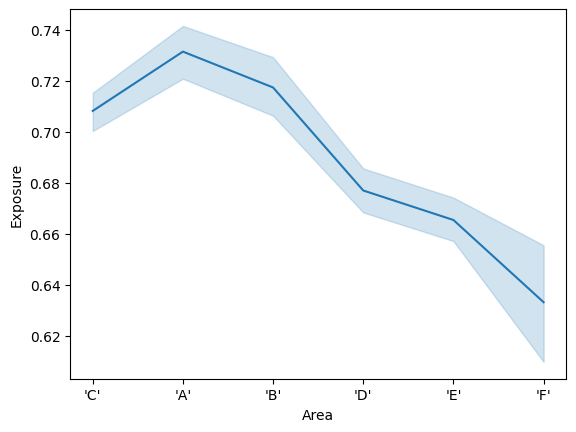

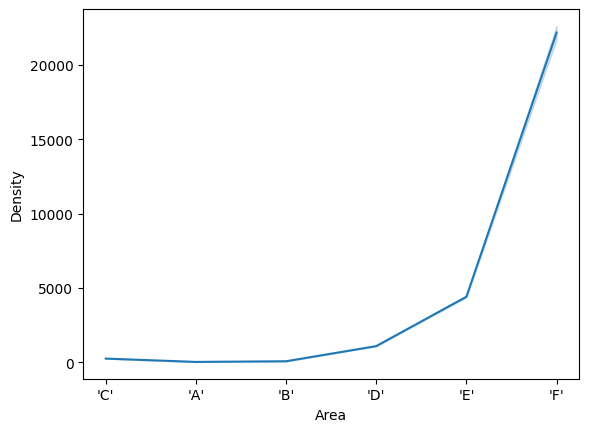

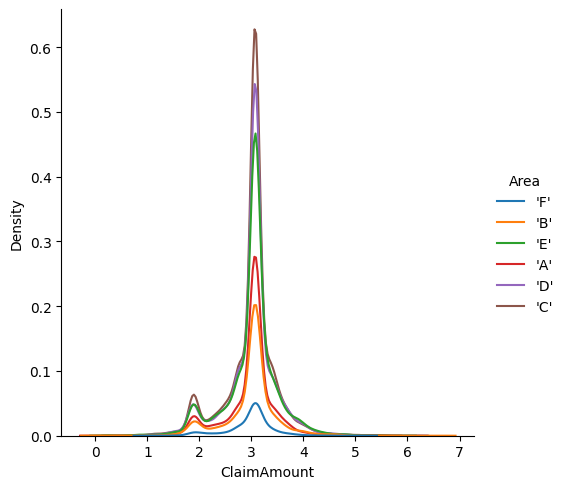

In [152]:
sns.lineplot(x = 'Area', y = 'Exposure', data = df_explore.sort_values(by="Exposure"))
plt.subplots()
sns.lineplot(x = 'Area', y = 'Density', data = df_explore.sort_values(by="Exposure"))
sns.displot(x = 'ClaimAmount', hue = 'Area', data = df_explore, kind = 'kde')
plt.show()

Region: It seems that Region is not a good indicator of ClaimAmount or Exposure, hence we can omit it from the features.

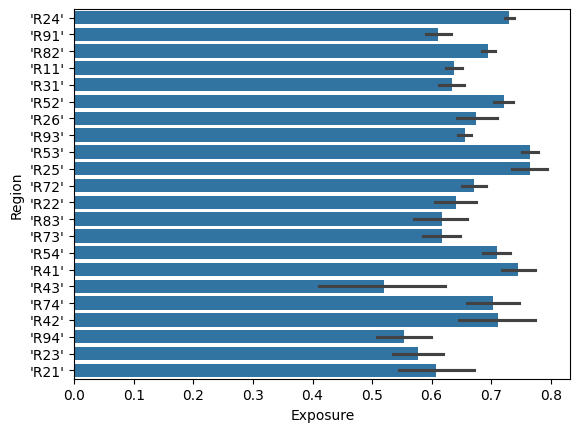

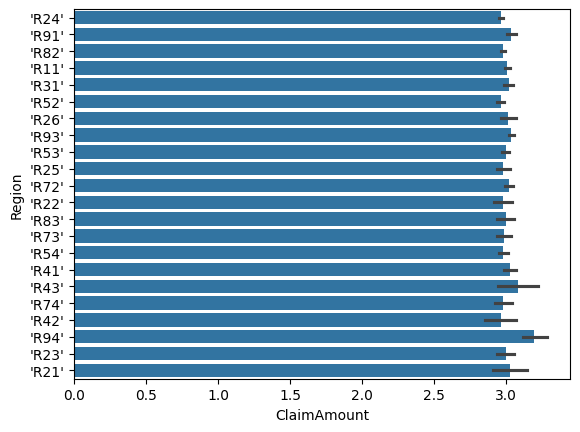

In [153]:
sns.barplot(y = 'Region', x = 'Exposure', data = df_explore.sort_values(by="Exposure"))
plt.subplots()
sns.barplot(y = 'Region', x = 'ClaimAmount', data = df_explore.sort_values(by="Exposure"))
plt.show()

DrivAge: There is a apparent correlation between driving age and the exposure. Additionally, the bonus-malus decreases with the driving age. This correlation almost occurs linearly (with coefficient -0.47 as can be seen in the table of correlation coefficients)

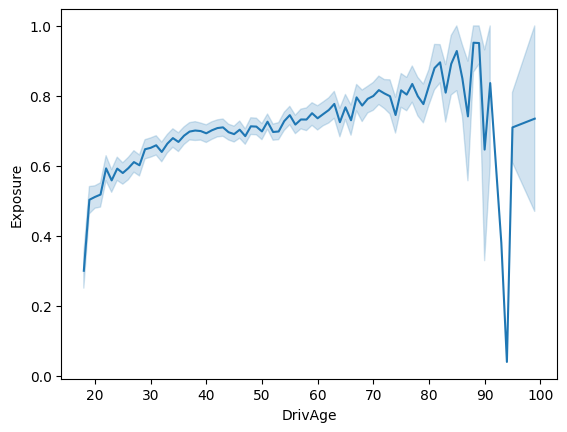

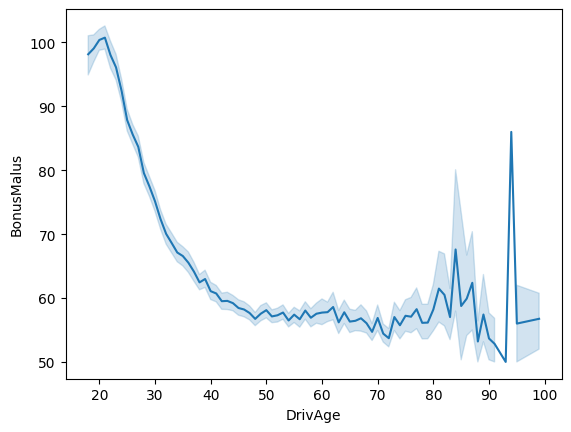

In [154]:
sns.lineplot(x = 'DrivAge', y = 'Exposure', data = df_explore)
plt.subplots()
sns.lineplot(x = 'DrivAge', y = 'BonusMalus', data = df_explore)
plt.show()

VehBrand: Some brands which have mostly low vehicle power submitted more claims.  

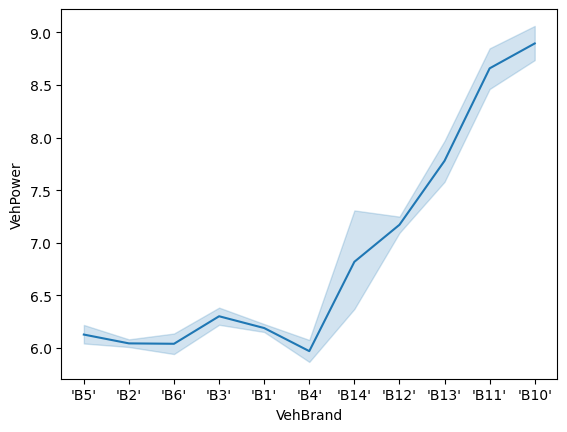

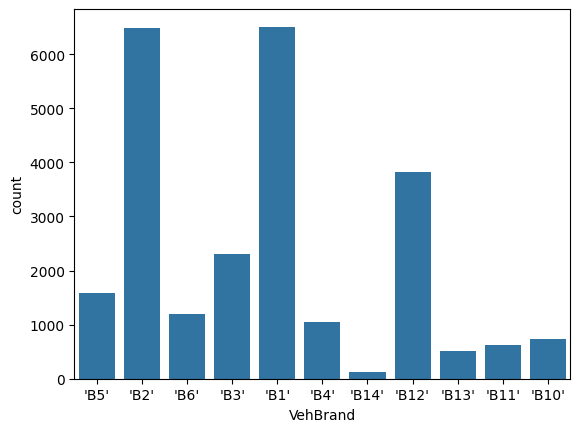

In [155]:
sns.lineplot(x = 'VehBrand', y = 'VehPower', data = df_explore.sort_values(by = 'VehPower'))
plt.subplots()
sns.countplot(x = 'VehBrand', data = df_explore.sort_values(by = 'VehPower'))
plt.show()

VehAge: The plots show that although really old vehicles (VehAge > 60) submit significantly fewer claims, have higher claim amounts. The reason probabaly is that most of the old cars are vintage cars. It is apparent these cases are outliers. 

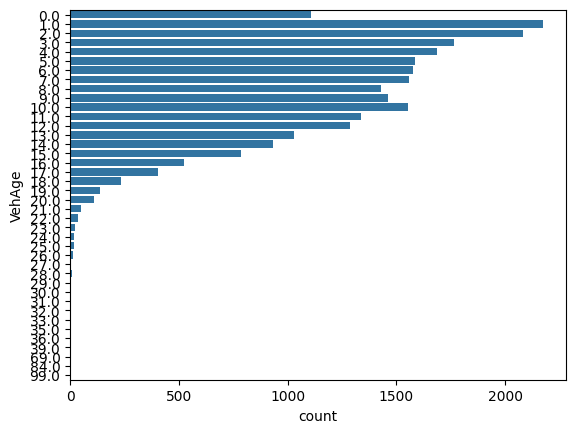

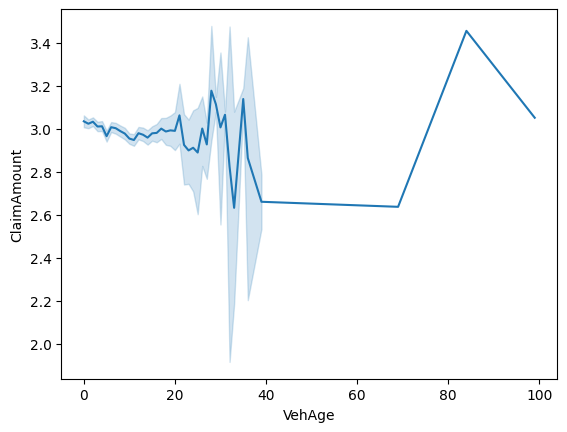

In [156]:
sns.countplot(y = 'VehAge', data = df_explore)
plt.subplots()
sns.lineplot(x = 'VehAge', y = 'ClaimAmount', data = df_explore)
plt.show()

## Pipline

As we have seen, the ClaimAmount does not follow a normal distribution even after log transformation. Additionally, there is no clear indication of linear dependence between features and responses. Therefore, we decide to proceed with decision trees. Additionally, we investigate the more suitable ensemble methods for our learning process: random forests and stochastic gradient descents. It is needless to say that we are dealing with numerical responses and hence our problem is of type regression. 

To address the model performance we choose the root-mean-squared error (RMSE). The RMSE has the advantage that it incorporates both the bias and the variance of the model estimator. Additionally, it has the same unit as the response. 

### Feature Engineering
Decision trees make informed decisions by stratifying the data based on the information gained by different features. Hence, we will limit the process of feature selection and leave it to the model to select the important features. Additionally, we refrain from transforming the claim amounts. This will allow the model to consider the effect of outliers. 

We consider the following feature engineering steps:
1. Dropping Density and Region (the claim amount is evenly distributed between regions and the information contained in density is most probably contained in the area variable)
2. Aggregate brands into 2 categories of high claim numbers and low claim numbers  
3. Converting the categorical features to numeric.

In [157]:
# droping density and region
dfx = df.drop(columns = ['Density', 'Region'])

# brand mapping
dfx["VehBrand"] = dfx["VehBrand"].str.replace("'","")
brand_mapping = {'B1':'high', 'B2':'high', 'B3':'few', 'B4':'few', 'B5':'few', 'B6':'few', 'B12':'few' , 'B10':'few', 'B11':'few', 'B13':'few', 'B14':'few'}
brands = dfx.VehBrand.map(brand_mapping)
dfx['Brands'] = brands
dfx.drop(columns = 'VehBrand')

# categories to numbers
col = dfx.select_dtypes(include='object').columns
dfx[col] = dfx.select_dtypes(include='object').astype('category')

for c in col:
    dfx[c] = dfx[c].cat.codes

dfx

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Exposure,ClaimAmount,Brands
0,5,7.0,1.0,61.0,50.0,3,1,0.75,303.00,0
1,1,12.0,5.0,50.0,60.0,3,0,0.14,1981.84,0
2,4,4.0,0.0,36.0,85.0,3,1,0.14,1456.55,0
3,5,10.0,0.0,51.0,100.0,3,1,0.62,10834.00,0
4,0,5.0,0.0,45.0,50.0,3,1,0.31,3986.67,0
...,...,...,...,...,...,...,...,...,...,...
24939,2,4.0,1.0,26.0,60.0,3,0,0.18,1324.40,0
24940,2,7.0,2.0,51.0,50.0,3,0,0.14,1769.88,0
24941,3,4.0,0.0,35.0,51.0,3,1,0.17,1288.28,0
24942,2,15.0,3.0,36.0,50.0,3,1,0.17,12230.40,0


### Modeling

Before we proceed with modeling, we will create a few functions and variables to fecelitate the process. 

In [158]:
# setting up hyper-parameters
seed = 123
min_leaves = 0.2
min_split = 0.2
depth = 5
estimators_num = 500
responses = ['ClaimAmount', 'Exposure']

In [159]:
# splitting data to train and test datasets
X = dfx.drop(responses, axis = 1)
def data_prep (data, response):
    y = data[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)
    return X_train, X_test, y_train, y_test

In [160]:
# Plots
def plots(features, model, claim_pred, claim_test, tlt, exp_pred = None, exp_test = None):
    # feature importance
    important_features = pd.Series(model.feature_importances_, index = features).sort_values()
    important_features.plot(kind = 'barh', title = 'Feature Importance')
    plt.subplots()
    res1 = claim_test - claim_pred
    res1 = (res1 - res1.mean())/res1.std()
    rs1 = sns.scatterplot(x = claim_pred, y = res1)
    rs1.set(xlabel = 'Predictions', ylabel = 'Standardized Residuals', title = tlt[0]) 
    if exp_pred is not None:
        print('')
        print('Entry with the large claim amount residual:')
        print(df[df['ClaimAmount']==np.array(claim_test[res1 > 10])[0]])
        print('Predicted value for this entry: ' + str(claim_pred[res1 > 10]))
        plt.subplots()
        res2 = exp_test - exp_pred
        res2 = (res2 - res2.mean())/res2.std()
        rs2 = sns.scatterplot(x = exp_pred, y = res2)
        rs2.set(xlabel = 'Predictions', ylabel = 'Standardized Residuals', title = tlt[1])
    plt.show()
    

In [161]:
## RMSE
def model_performance(X_train, X_test, y_train, y_test, model, tlt):
    train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, train_pred, multioutput = 'raw_values')**(1/2)
    print('Training RMSE: ' + str(rmse_train))

    y_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred, multioutput = 'raw_values')**(1/2)
    print('Test RMSE: ' + str(rmse_test))

    if len(pd.DataFrame(y_train).columns) == 2:
        out_pred = (y_pred[:,0]/y_pred[:,1]).mean()
        out_test = (np.array(y_test['ClaimAmount'])/np.array(y_test['Exposure'])).mean()
        print(' Pred - Expected Premium ' + str(out_pred))
        print(' True - Expected Premium ' + str(out_test))
        plots(X.columns, model, y_pred[:,0], y_test['ClaimAmount'], tlt, y_pred[:,1], y_test['Exposure'])
    else:
        plots(X.columns, model, y_pred, y_test, tlt)
        out_pred = y_pred
        out_test = y_test
    return rmse_train, rmse_test, out_pred, out_test

Furthermore, the seed is set and a few hyperparameters are defined beforehand. Note that, each model's performance depends on the value of their hyperparameters. A better approach to find the best model within its family of models is hyperparameter tuning. However, this is not the aim of this study. 

In [162]:
# setting up hyper-parameters
seed = 123
min_leaves = 0.2
min_split = 0.2
depth = 6
estimators_num = 500
responses = ['ClaimAmount', 'Exposure']

Decision Tree: the first model that we consider is a simple decision tree. To avoid overfitting, we set the depth parameter as half of the number of features. 

Training RMSE: [1.79305081e+04 3.09775814e-01]
Test RMSE: [4.79744662e+04 3.09878694e-01]
 Pred - Expected Premium 3425.644672058513
 True - Expected Premium 10577.157759576423

Entry with the large claim amount residual:
     Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density  \
7487  'B'       9.0    13.0     19.0       100.0     'B2'  Regular     93.0   

     Region  Exposure  ClaimAmount  
7487  'R24'      0.22   4075400.56  
Predicted value for this entry: [3067.60051158]


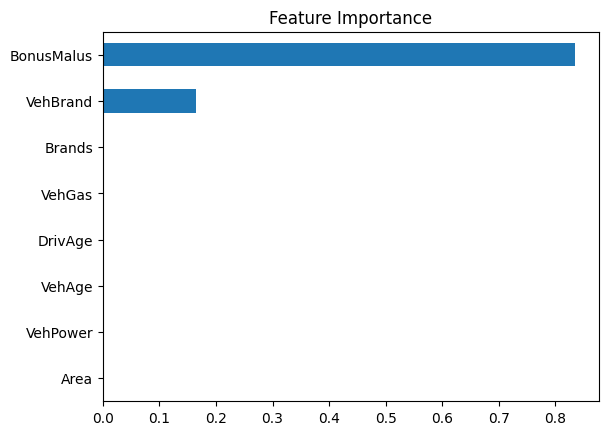

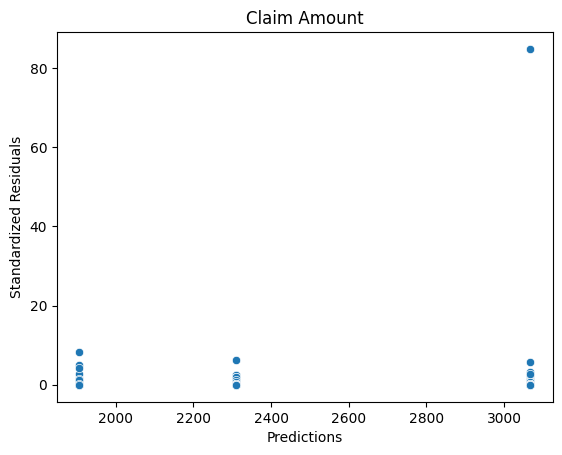

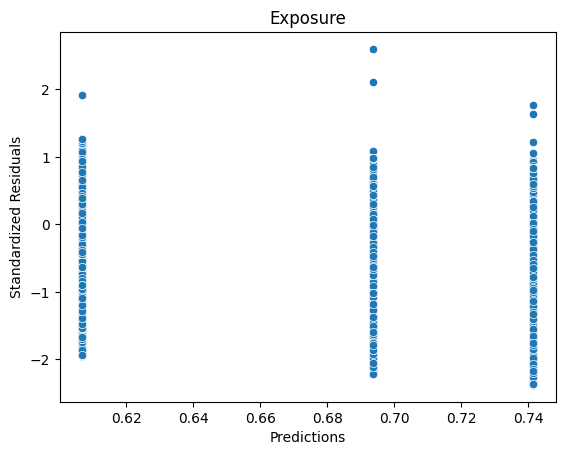

In [163]:
# model 1. Decision Tree
X_train, X_test, y_train, y_test = data_prep (dfx, responses)
dt_base = DecisionTreeRegressor(max_depth = depth, 
                                min_samples_leaf = min_leaves, 
                                min_samples_split = min_split, 
                                random_state = seed)
dt_base.fit(X_train, y_train)
rmse_train, rmse_test, out_pred, out_test = model_performance(X_train, X_test, y_train, y_test, dt_base, tlt = list(['Claim Amount', 'Exposure']))

Random Forests: here an extra parameter namely the number of estimators is specified. This is the number of bootstrap datasets fed to the decision tree. Furthermore, in each step a random subset of features are chosen to train the tree. This helps with the decorrelation of trees and helps the model to generalize.  

Training RMSE: [1.79302467e+04 3.09065065e-01]
Test RMSE: [4.79764556e+04 3.09407484e-01]
 Pred - Expected Premium 3405.3324169004845
 True - Expected Premium 10577.157759576423

Entry with the large claim amount residual:
     Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density  \
7487  'B'       9.0    13.0     19.0       100.0     'B2'  Regular     93.0   

     Region  Exposure  ClaimAmount  
7487  'R24'      0.22   4075400.56  
Predicted value for this entry: [2862.06769973]


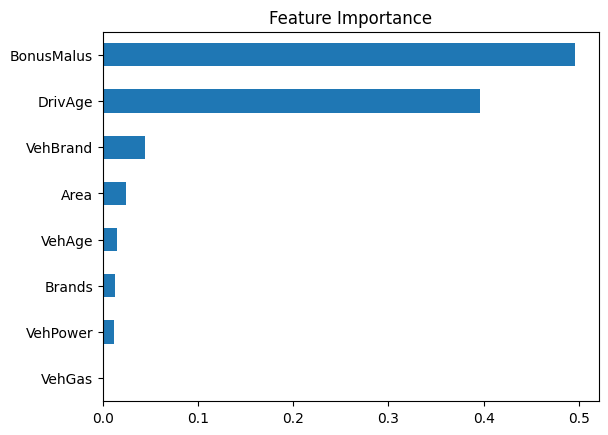

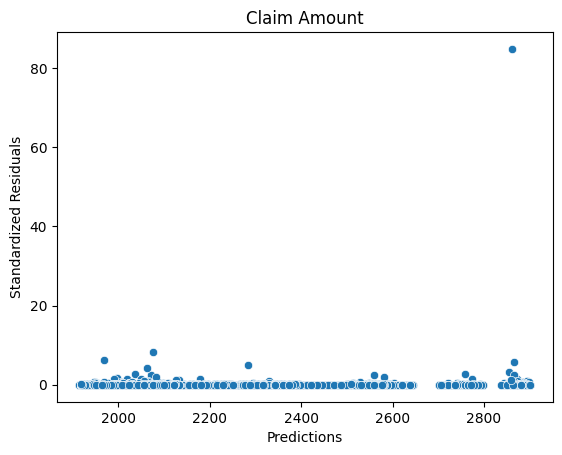

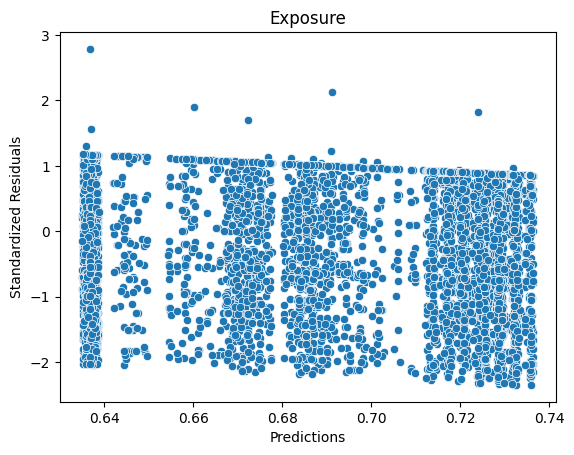

In [164]:
# model 2. Random Forrests
X_train, X_test, y_train, y_test = data_prep (dfx, responses)
rfr = RandomForestRegressor(max_depth = depth, 
                            min_samples_leaf = min_leaves, 
                            min_samples_split = min_split, 
                            random_state = seed, 
                            n_estimators = estimators_num, 
                            n_jobs = -1)
rfr.fit(X_train, np.array(y_train))
rmse_train, rmse_test, out_pred, out_test = model_performance(X_train, X_test, y_train, y_test, rfr, tlt = ['Claim Amount', 'Exposure'])

Model 3. Sochastic Gradient Bossting (SGB): this model has three extra parameters. Learning rate, subsample, and max_features. For better generalization the values are set as below. 

Training RMSE: [13337.43509655]
Test RMSE: [48376.82514563]


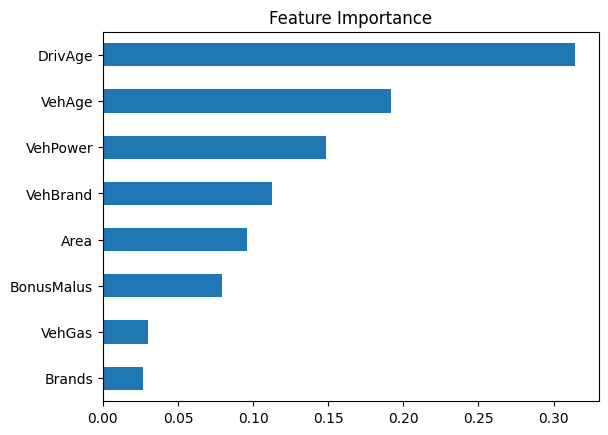

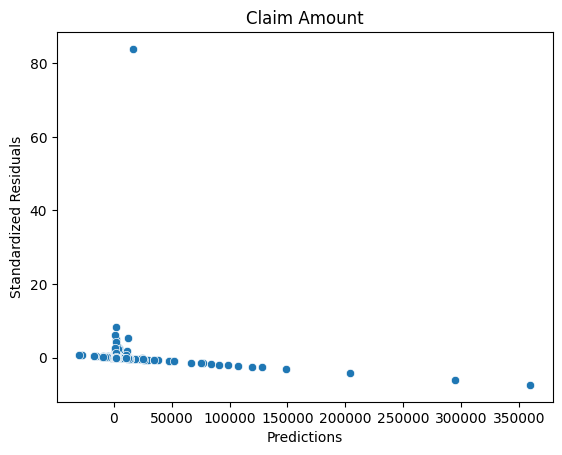

Training RMSE: [0.28592788]
Test RMSE: [0.29670509]


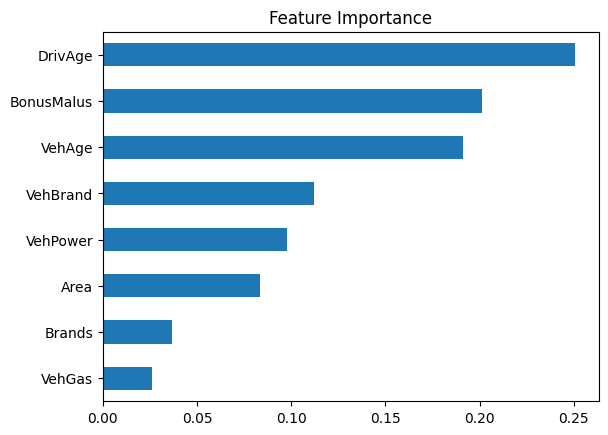

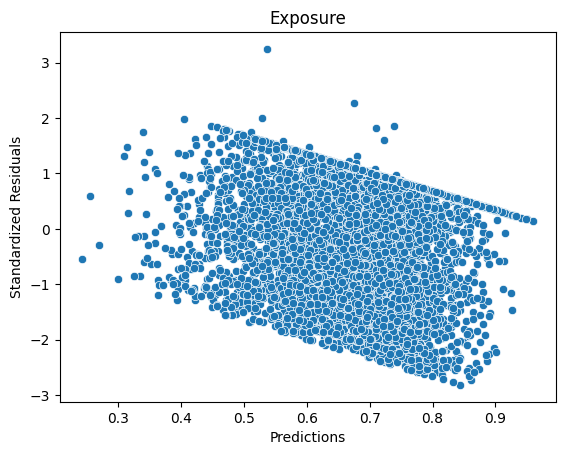

 Pred - Expected Premium 3835.488209006164
 True - Expected Premium 10577.157759576423


In [165]:
# Model 3. Stochastic Gradient Boosting
X_train, X_test, y_train, y_test = data_prep (dfx, 'ClaimAmount')
SGB_claim = GradientBoostingRegressor(max_depth = depth, 
                                      learning_rate = 0.01, 
                                      n_estimators = estimators_num, 
                                      subsample = 0.2, 
                                      max_features = 0.3, 
                                      random_state = seed)
SGB_claim.fit(X_train, y_train)
rmse_train, rmse_test, out_claim, out_claim_t = model_performance(X_train, X_test, y_train, y_test, SGB_claim, tlt = ['Claim Amount'])
plt.subplots()
X_train, X_test, y_train, y_test = data_prep (dfx, 'Exposure')
SGB_exp = GradientBoostingRegressor(max_depth = depth, 
                                    learning_rate = 0.01, 
                                    n_estimators = estimators_num, 
                                    subsample = 0.2, 
                                    max_features = 0.3, 
                                    random_state = seed)
SGB_exp.fit(X_train, y_train)
rmse_train, rmse_test, out_exp, out_exp_t = model_performance(X_train, X_test, y_train, y_test, SGB_exp, tlt = ['Exposure'])
expected_claim = (out_claim/out_exp).mean()
expected_claim_t = (out_claim_t/out_exp_t).mean()
print(' Pred - Expected Premium ' + str(expected_claim))
print(' True - Expected Premium ' + str(expected_claim_t))


## Conclusions
The models perform rather poorly. In particular, there is a significant difference between the train and the test RMSE of claim amount predictions. This can be due to overfitting, as the residuals do not indicate a high variation. One advantage of the ensemble methdods is considering different features in modeling, leading to decorrelation of response against a fixed set of features. Among those models that are trained, the decision tree and random forest have smaller RMSE and hence are better models to predict claim Amounts. On the other hand, SGB does a better job at predicting the exposure. It has a smaller RMSE. To further investigate the dataset and find a better model one can apply the following:

1. Apply hyper-parameter tuning and Cross-Validation: although decision trees and the extended ensemble models seem to be a good choice here, the best model within the family of the models considered above is obtained by performing a grid search within the parameter space associated with these models.
2. Outlier detection and removal: The model's performance is highly dependent on the random seed and the assignment of values to the train and test datasets which have values at the right tail of claim amount distribution. This weakens the model's performance. Therefore, it is important to consider an extra pre-processing step in which the outliers are detected and removed. Although this will not guarantee better model performance, it is rather necessary to investigate. 
3. Fit models on stratified data, i.e., use a categorical feature to stratify data (e.g., Area) and then fit the models: essentially, since the dataset is large, a good estimate for policyholder's premium is the average expected yearly claim (EYC), i.e., claim amount divided by exposure, as the law of large numbers ensures convergence to the expected value assuming that all policyholders belong to the same population. Additionally, a better estimate for EYC is derived by stratifying the dataset corresponding to a categorical variable and deriving the EYC, e.g.,

In [166]:
df.groupby(['Area', 'VehBrand'])['ClaimAmount'].mean()

Area  VehBrand
'A'   'B1'        2459.732859
      'B10'       2152.947439
      'B11'       2530.400400
      'B12'       3082.635225
      'B13'       1801.799706
                     ...     
'F'   'B2'        1425.964200
      'B3'        2753.951290
      'B4'        1313.107857
      'B5'        1265.292941
      'B6'        2128.539310
Name: ClaimAmount, Length: 66, dtype: float64

In [167]:
df.groupby(['Area', 'VehBrand'])['ClaimAmount'].std()

Area  VehBrand
'A'   'B1'        14384.785426
      'B10'        5454.576022
      'B11'        7839.030230
      'B12'       20364.731753
      'B13'        1832.286937
                      ...     
'F'   'B2'         1218.860708
      'B3'        14471.654378
      'B4'          964.849359
      'B5'          896.566682
      'B6'         3921.087963
Name: ClaimAmount, Length: 66, dtype: float64

One can perform an ANOVA test to see if there is in fact difference between means in these different populations. This is all possible as the dataset remains large even after stratification. Furthermore, one can fit models on these stratified datasets to find a better estimation for the responses. This is however an exhausting approach!